# Stochastic Simulation - Coursework 2023

This assignment has two parts and graded over **100 marks**. Some general remarks:

- The assignment is due on **11 December 2023, 1PM GMT**, to be submitted via Blackboard (see the instructions on the course website).
- You should use this .ipynb file as a skeleton and you should submit a PDF report. Prepare the IPython notebook and export it as a PDF. If you can't export your notebook as PDF, then you can export it as HTML and then use the "Print" feature in browser (Chrome: File -> Print) and choose "Save as PDF". 
- Your PDF should be no longer than 20 pages. But please be concise.
- You can reuse the code from the course material but note that this coursework also requires novel implementations. Try to personalise your code in order to avoid having problems with plagiarism checks. You can use Python's functions for sampling random variables of all distributions of your choice.
- **Please comment your code properly.**

Let us start our code.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

rng = np.random.default_rng(36) # You can change this.

## Q1: Model Selection via Perfect Monte Carlo (40 marks)

Consider the following probabilistic model
\begin{align*}
    p(x) &= \mathcal{N}(x; 5, 0.01), \\
    p(y_i|x) &= \mathcal{N}(y_i; \theta x, 0.05),
\end{align*}
for $i = 1, \ldots, T$ where $y_i$ are conditionally independent given $x$. You are given a dataset (see it on Blackboard) denoted here as $y_{1:T}$ for $T = 100$. As defined in the course, we can find the marginal likelihood as
\begin{align*}
p_\theta(y_{1:T}) = \int p_\theta(y_{1:T}|x) p(x) \mathrm{d} x,
\end{align*}
where we have left $\theta$-dependence in the notation to emphasise that the marginal likelihood is a function of $\theta$.

Given the samples from prior $p(x)$, we can identify our test function above as $\varphi(x) = p_\theta(y_{1:T}|x)$.

**(i)** The first step is to write a log-likelihood function of $y_{1:T}$, i.e., $p_\theta(y_{1:T} | x)$. Note that, this is the joint likelihood of conditionally i.i.d. observations $y_i$ given $x$. This function should take input the data set vector `y` as loaded from `y_perfect_mc.txt` below, $\theta$ (scalar), and $x$ (scalar), and `sig` (likelihood variance which is given as 0.05 in the question but leave it as a variable) values to evaluate the log-likelihood. Note that log-likelihood will be a **sum** in this case, over individual log-likelihoods. **<span style="color:blue">(10 marks)</span>**

In [2]:
# put the dataset in the same folder as this notebook
# the following line loads y_perfect_mc.txt
y = np.loadtxt('y_perfect_mc.txt')
y = np.array(y, dtype=np.float64)

def single_log_likelihood(z, x, theta, sig): # via EDstem, sig should be the variance
    return  np.log(1/np.sqrt(2*np.pi*sig) ) - ((z - theta*x)**2) /(2*sig)


#print(np.exp(single_likelihood(1,1,1, np.sqrt(0.2))))
def log_likelihood(y, x, theta, sig):  # note: sig is just the standard dev and not the variance!!
    # computes the sum of log likelihoods of the log likelihoods: log ( p( y_i | x, \theta)
    d = 0
    for i in y:
        d += single_log_likelihood(i,x,theta,sig)
    return d 

# uncomment and evaluate your likelihood (do not remove)
#print(log_likelihood(y, 1, 1, 1))
#print(log_likelihood(y, 1, 1, 0.1))
#print(log_likelihood(y, -1, 2, 0.5))

**(ii)** Write a logsumexp function. Let $\mathbf{v}$ be a vector of log-quantities and assume we need to compute $\log \sum_{i=1}^N \exp(v_i)$ where $\mathbf{v} = (v_1, \ldots, v_N)$. This function is given as
\begin{align*}
\log \sum_{i=1}^N \exp(v_i) = \log \sum_{i=1}^N \exp(v_i - v_{\max}) + v_{\max},
\end{align*}
where $v_{\max} = \max_{i = 1,\ldots,N} v_i$. Implement this as a function which takes a vector of log-values and returns the log of the sum of exponentials of the input values. **<span style="color:blue">(10 marks)</span>**

In [3]:
def logsumexp(v):
    # we use the second form to limit possible overflows of intigers/ longs
    v_max = np.amax(v)
    d = 0
    for i in v:
        d += np.exp(i-v_max)
    d = np.log(d) + v_max
    return d 

# uncomment and evaluate your logsumexp function (do not remove)
#print(logsumexp(np.array([1, 2, 3])))
#print(logsumexp(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])))
#print(logsumexp(np.array([5, 6, 9, 12])))

**(iii)** Now we are at the stage of implementing the log marginal likelihood estimator. Inspect your estimator as described in Part (i). Its particular form is not implementable without using the trick you have coded in Part (iii). Now, implement a function that returns the **log** of the MC estimator you derived in Part (i). This function will take in

- `y` dataset vector
- $\theta$ parameter (scalar)
- `x_samples` (`np.array` vector) which are $N$ Monte Carlo samples.
- a variance (scalar) variable `sig` for the joint log likelihood $p_\theta(y_{1:T} | x)$ that will be used in `log_likelihood` function (we will set this to 0.05 as given in the question).

**Hint:** Notice that the log of the MC estimator of the marginal likelihood takes the form
\begin{align*}
\log \frac{1}{N} \sum_{i=1}^N p_\theta(y_{1:T} | x^{(i)}),
\end{align*}
as given in the question. You have to use $p_\theta(y_{1:T} | x^{(i)}) = \exp(\log p_\theta(y_{1:T} | x^{(i)}))$ to get a `logsumexp` structure, i.e., $\log$ and $\text{sum}$ (over particles) and $\exp$ of $\log p_\theta(y_{1:T} | x^{(i)})$ where $i = 1, \ldots, N$ and $x^{(i)}$ are the $N$ Monte Carlo samples (do **not** forget $1/N$ term too). Therefore, now use the function of Part (i) to compute $\log p_\theta(y_{1:T} | x^{(i)})$ for every $i = 1,\ldots, N$ and Part (ii) `logsumexp` these values to compute the estimate of log marginal likelihood. **<span style="color:blue">(10 marks)</span>**

In [4]:
def log_marginal_likelihood(y, theta, x_samples, sig): # fill in the arguments
    N = x_samples.size
    s = log_likelihood(y, x_samples, theta, sig)
    s = 1/N * s
    #print(s)

    return logsumexp(s)# fill in the return value

# uncomment and evaluate your marginal likelihood (do not remove)

#print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 1))
#print(log_marginal_likelihood(y, 1, np.array([-1, 1]), 0.1))
#print(log_marginal_likelihood(y, 2, np.array([-1, 1]), 0.5))

# note that the above test code takes 2 dimensional array instead of N particles for simplicity

**(iv)** We will now try to find the most likely $\theta$. For this part, you will run your `log_marginal_likelihood` function for a range of $\theta$ values. Note that, for every $\theta$ value, you need to sample $N$ new samples from the prior (do not reuse the same samples). Compute your estimator of the $\log \hat{\pi}_{\text{MC}}^N \approx \log p_\theta(y_{1:T})$ for $\theta$-range given below. Plot the log marginal likelihood estimator as a function of $\theta$. **<span style="color:blue">(5 marks)</span>**

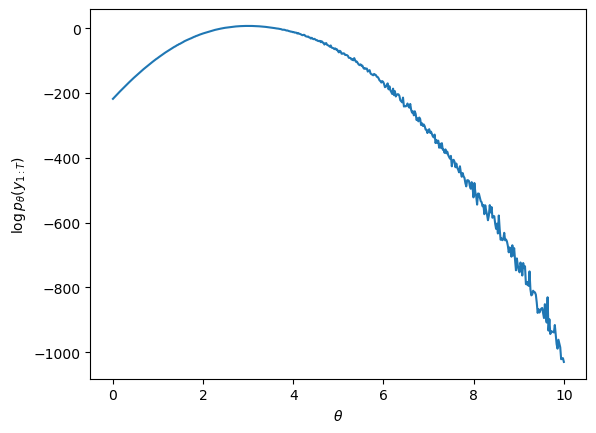

In [5]:
sig =  0.05 
sig_prior = 0.01 # since p(x) = N(x; 5, 0.01)  # I assume 0.01 here is sig_prior^2
mu_prior = 5.0

N = 1000

theta_range = np.linspace(0, 10, 500)
log_ml_list = np.array([]) # you can use np.append to add elements to this array

# fill in your code here
for theta in theta_range:
    #print(theta)
    x_samples = np.random.normal(mu_prior,np.sqrt(sig_prior),N) # random normal takes in the std dev not the variance
    #print(log_marginal_likelihood(y, theta, x_samples, sig))
    log_ml_list = np.append(log_ml_list,log_marginal_likelihood(y, theta, x_samples, sig))
# uncomment and plot your results (do not remove)
#print(log_ml_list)
plt.plot(theta_range, log_ml_list)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\log p_\theta(y_{1:T})$')
plt.show()

**(v)** Now you have `log_ml_list` variable that corresponds to marginal likelihood values in `theta_range`. Find the $\theta$ value that gives the maximum value in this list and provide your final estimate of most likely $\theta$. **<span style="color:blue">(5 marks)</span>**

In [6]:
# You code goes here
p_max = log_ml_list[0]
theta_max = 0

for i in range(log_ml_list.size):
    if log_ml_list[i] > p_max:
        p_max = log_ml_list[i]
        theta_max = theta_range[i]

theta_est = theta_max
# print your theta estimate, e.g.:
print(theta_est)

3.006012024048096


## Q2: Posterior sampling (35 marks)

In this question, we will perform posterior sampling for the following model
\begin{align*}
    p(x) &\propto \exp(-x_1^2/10 - x_2^2/10 - 2 (x_2 - x_1^2)^2), \\
    p(y | x) &= \mathcal{N}(y; H x, 0.1)
\end{align*}
where $H = [0, 1]$. In this exercise, we assume that we have observed $y = 2$ and would like to implement a few sampling methods.

Before starting this exercise, please try to understand how the posterior density should look like. The discussion we had during the lecture about Exercise 6.2 (see Panopto if you have not attended) should help you here to understand the posterior density. Note though quantities and various details are **different** here. You should have a good idea about the posterior density before starting this exercise to be able to set the hyperparameters such as the chain-length, proposal noise, and the step-size.

In [7]:
y = np.array([2.0])
sig_lik = 0.1
H = np.array([0, 1])

**(i)** In what follows, you will have to code the log-prior and log-likelihood functions. Do **not** use any library, code the log densities directly. **<span style="color:blue">(5 marks)</span>**

In [8]:
def prior(x): # for visualisation purposes ; different than the banana densities in the notes!
    p = np.exp(-(x[0]**2)/10 - (x[1]**2)/10 - 2*(x[1]-x[0]**2)**2)   
    return p

def log_prior(x): 
    return -(x[0]**2)/10 - (x[1]**2)/10 - 2*(x[1]-x[0]**2)**2 

def log_likelihood(y, x, sig): 
    #note that y is just a scalar so Hx is just x[1]:
    #note sig should be in fact the variance!
    return  np.log(1/np.sqrt(2*np.pi*sig) ) - (((y - x[1])**2) /(2*sig)) # I am not sure how to code this without np.log,
    # but I assume the goal was not to read out the likelihood directly from some library

#print(log_prior([0, 1]))
#print(np.log(prior([0, 1])))
#print(np.exp(log_likelihood(y, np.array([0, 0.0]), sig_lik)))
#print(np.exp(log_likelihood(y, np.array([0, 1.0]), sig_lik)))
#print(np.exp(log_likelihood(y, np.array([0, 2.0]), sig_lik)))
#print(np.exp(log_likelihood(y, np.array([0, 3.0]), sig_lik)))
#print(np.exp(log_likelihood(y, np.array([0, 4.0]), sig_lik)))


**(ii)** Next, implement **the random walk Metropolis algorithm (RWMH)** for this target. Set an appropriate chain length, proposal variance, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

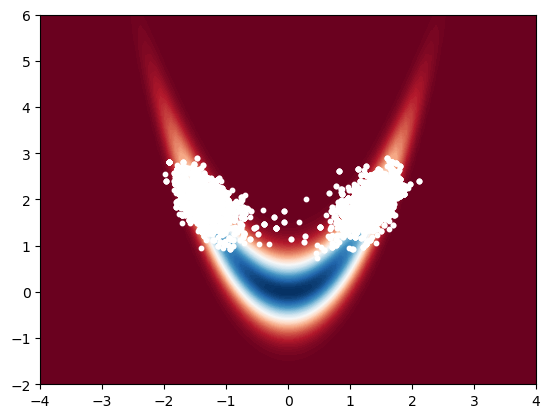

In [9]:
N = 10000
X_samples = np.zeros((N,2))
#initial data
X_samples[0,:] = np.array([0.0, 0.0])

sig_proposal = 0.6 # parmeter to optimise, note  that it is the variance of the proposal 

def propose(x_prev): #proposes an X' from X[n-1] according to a Gaussian(x_next ; X[n-1], sig_proposal **2)
    return  x_prev + np.random.normal(0,np.sqrt(sig_proposal),2)
    
def log_p_star(x): # unnormalised log posterior
    return log_likelihood(y,x,sig_lik) + log_prior(x)

def compute_log_r(x_prime, x_prev): 
    # since the gaussian proposal is symmetric : q(x_prime | x_prev) = q(x_prev | x_prime),
    # r simplifies to the division of p_star terms
    log_r = log_p_star(x_prime) - log_p_star(x_prev)
    #print(log_likelihood(x_prev[1], x_prime, sig_lik) , log_likelihood(x_prime[1],x_prev,sig_lik))
    return log_r
#print('likelihood at [0,2]:')
#print(np.exp(log_p_star(np.array([0,2.0]))))

#print('likelihood at [0,0]:')
#print(np.exp(log_p_star(np.array([0,0.0]))))

nr_ac = 0
for i in range(1,N):
    x_prop = propose(X_samples[i-1,:])
    ##print(x_prop)
    log_r = compute_log_r(x_prop, X_samples[i-1,:])
    # note that we are operating with log likelihoods, so we shall compare log(r) with log(u)
    u = np.random.uniform(0,1)
    log_u = np.log(u)
    ####print('computed r', np.exp(log_r), 'random sample u', u)
    if log_r >= log_u:
        X_samples[i,:] = x_prop
        nr_ac+=1
        ##print('a')
    else:
        X_samples[i,:] = X_samples[i-1,:]
        ##print('no')
#print('acc rate: ', nr_ac/N)

# burn in the first smaples to make the process stationary
burnin = 50

x = X_samples[burnin: ]   
# uncomment and plot your results (do not remove)
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        #Z_bb[i, j] = (log_likelihood(y,np.array([X_bb[i, j], Y_bb[i, j]]),sig_lik))
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]]) #+(log_likelihood(y,np.array([X_bb[i, j], Y_bb[i, j]]),sig_lik))
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x[:, 0], x[:, 1], s=10 , c='white')
plt.show()


## wrong, it should follow the banana more. error in 'importance' of the prior 


**(iii)** Now implement **Metropolis-adjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

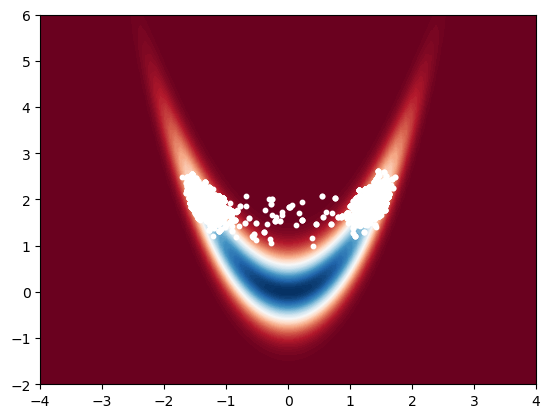

In [10]:
gam = 0.11
sig_proposal_MALA = 0.5 # variance of the random noise
N1 = 15000
_burn_in = 1000


def grad_log_prior(x): #different than the banana 
    d1 = -0.2*x[0] + 8*x[0]*x[1] - 8*x[0]**3
    d2 = -0.2*x[1] + 4*x[0]**2 - 4*x[1]
    return np.array([d1, d2])

def grad_log_likelihood(x, y, sig): #sig is always the variance!
    return [ 0.0,  -1/sig * float( x[1] - y)]

def grad_log_MALA_kernel(x, y, sig): # used to compute the proposal for X_samples
    # we use that grad(log(p(y|x)*p(x))) = grad(log(p(y|x)) + grad(log(p(x)))
    return grad_log_prior(x) + grad_log_likelihood(x, y, sig)

def propose_MALA(x_prev): #implemented like (5.6) in lecture notes
    v = np.random.normal(0, 1, 2) # this is the random noise component. We then scale it times its std. dev. of sqrt(2\gamma)   
    x_new =  x_prev +  gam * grad_log_MALA_kernel(x_prev, y, sig_lik) + np.sqrt(2 * gam) * v
    return x_new

def log_p_star_MALA(x): 
    return log_likelihood(x,y,sig_lik) + log_prior(x)

def log_q_MALA(x_tar,x_known):
    #compute q(x_tar|x_known) according to 5.6 in the lecture notes

    var = 2 * gam #  the variance of the proposal q
    mu = x_known - gam * grad_log_MALA_kernel(x_known,y,sig_lik) # its mean. 
    #the joint probability of this gaussian can be written as a product of marinal probabilities,
    
    return np.log(1/(2 * np.pi * var)) - ((x_tar[0] - mu[0])**2 / (2 * var)) - ((x_tar[1] - mu[1])**2 / (2 * var))
    

def compute_log_r(x_prime, x_prev): # because we are operationg with log likelihoods, the products and divisions in 
    #the definition of r change into sums and differences of the log probabilities.
    log_r = log_p_star(x_prime) + log_q_MALA(x_prev, x_prime) - log_p_star(x_prev)  - log_q_MALA(x_prime, x_prev)
    return log_r



X_samples_MALA = np.zeros((N1,2))
X_samples_MALA[0,:] = np.array([0, 0])

#nr_acc = 0
for i in range(1,N1):
    x_prop = propose_MALA(X_samples_MALA[i-1,:])
    log_r = compute_log_r(x_prop, X_samples_MALA[i-1,:])
    # note that we are operating with log likelihoods, so compare log(r) with log(u)
    u = np.random.uniform(0,1)
    log_u = np.log(u)
    if log_r >= log_u:
        X_samples_MALA[i,:] = x_prop
    else:
        X_samples_MALA[i,:] = X_samples_MALA[i-1,:]
#print('acceptance rate' , nr_acc/N1)

#burn in the samples to make the process stationary
X_MALA = X_samples_MALA[_burn_in: ]

# plots
x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
        
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(X_MALA[:, 0], X_MALA[:, 1], s=10 , c='white')
plt.show()

**(iv)** Next, implement **unadjusted Langevin algorithm**. For this, you will need to code the gradient of the density and use it in the proposal as described in the lecture notes. Set an appropriate chain length, step-size, and `burnin` value. Plot a scatter-plot with your samples (see the visualisation function below). Use log-densities only. **<span style="color:blue">(10 marks)</span>**

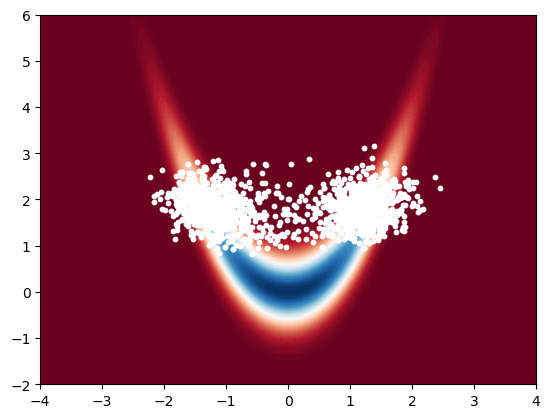

In [11]:
#v = np.random.normal(0,1,2)
#X[i, :] = X[i-1,:] + gamma * grad_log_pstar(X[i-1,:]) + ((2*gamma)**2) * v
#here we dont sample the u and just accept the random proposal 
gam = 0.04
N_ULA = 1500
burn_in_ULA = 100


def grad_log_ULA_kernel(x, y, sig): #probably dont need this function, I use it to compute the proposal for X_samples
    #print(x , ' grad ' , grad_log_prior(x) + grad_log_likelihood(x, y, sig))
    return grad_log_prior(x) + grad_log_likelihood(x, y, sig)

def propose_ULA(x_prev): #implemented like (5.6) in lecture notes
    v = np.random.normal(0, 1, 2)
    #print('det part of the proposal started from ', x_prev, 'is' , x_prev + gam * grad_log_MALA_kernel(x_prev, y, sig_lik))
    
    x_new =  x_prev + gam * grad_log_ULA_kernel(x_prev, y, sig_lik) + np.sqrt(2 * gam) * v
    return x_new


X_samples_ULA = np.zeros((N_ULA,2))
X_samples_ULA[0,:] = np.array([0, 0])

for i in range(1,N_ULA):
    x_prop = propose_ULA(X_samples_ULA[i-1,:])
    #print(x_prop)
    X_samples_ULA[i,:] = x_prop
        

# burn in the initial values
x_ULA = X_samples_ULA[burn_in_ULA: ]

x_bb = np.linspace(-4, 4, 100)
y_bb = np.linspace(-2, 6, 100)
X_bb , Y_bb = np.meshgrid(x_bb , y_bb)
Z_bb = np.zeros((100 , 100))
for i in range(100):
    for j in range(100):
        Z_bb[i, j] = prior([X_bb[i, j], Y_bb[i, j]])
plt.contourf(X_bb , Y_bb , Z_bb , 100 , cmap='RdBu')
plt.scatter(x_ULA[:, 0], x_ULA[:, 1], s=10 , c='white')
plt.show()

## Q3: Gibbs sampling for 2D posterior (25 marks)

In this question, you will first derive a Gibbs sampler by deriving full conditionals. Then we will describe a method to estimate marginal likelihoods using Gibbs output (and you will be asked to implement the said method given the description).

Consider the following probabilistic model
\begin{align*}
p(x_1) &= \mathcal{N}(x_1; \mu_1, \sigma_1^2), \\
p(x_2) &= \mathcal{N}(x_2; \mu_2, \sigma_2^2), \\
p(y | x_1, x_2) &= \mathcal{N}(y; x_1 + x_2, \sigma_y^2),
\end{align*}
where $y$ is a scalar observation and $x_1, x_2$ are latent variables. This is a simple model where we observe a sum of two random variables and want to construct possible values of $x_1, x_2$ given the observation $y$.

**(i)** Derive the Gibbs sampler for this model, by deriving full conditionals $p(x_1 | x_2, y)$ and $p(x_2 | x_1, y)$ (You can use Example 3.2 but note that this case is different). **<span style="color:blue">(10 marks)</span>**

**Solution:**

We use Bayes' rule to derive: $p_{*,1}(x_1 | y, x_2)$ : 

\begin{align*}
    p_{*,1}(x_1 | y, x_2) &= \frac{p(y | x_1, x_2) \cdot p(x_1 | x_2)}{p(y | x_2)} \\
    &\propto p(y | x_1, x_2) \cdot p(x_1 | x_2)  = \mathcal{N}(y; x_1 + x_2, \sigma_y^2)  \mathcal{N}(x_1; \mu_1, \sigma_1^2)
    &= \mathcal{N}(x_1; y - x_2, \sigma_y^2) \mathcal{N}(x_1; \mu_1, \sigma_1^2)\\
    &= \mathcal{N} ( x_1; 
    \frac{ \mu_1 \sigma_y^2 + (y - x_2) \sigma_1^2}{\sigma_1^2 + \sigma_y^2}, 
    \frac{ \sigma_1^2  \ \sigma_y^2}{\sigma_1^2 + \sigma_y^2})
\end{align*}
and similarly we obtain:
\begin{align*}
     p_{*,2}(x_2 | y, x_1) \propto
     \mathcal{N} ( x_2; 
    \frac{ \mu_2 \sigma_y^2 + (y - x_1) \sigma_2^2}{\sigma_2^2 + \sigma_y^2}, 
    \frac{ \sigma_2^2  \ \sigma_y^2}{\sigma_2^2 + \sigma_y^2})
\end{align*}


**(ii)** Let us set $y = 5$, $\mu_1 = 0$, $\mu_2 = 0$, $\sigma_1 = 0.1$, $\sigma_2 = 0.1$, and $\sigma_y = 0.01$.

Implement the Gibbs sampler you derived in Part (i). Set an appropriate chain length and `burnin` value. Plot a scatter plot of your samples (see the visualisation function below). Discuss the result: Why does the posterior look like this? **<span style="color:blue">(15 marks)</span>**

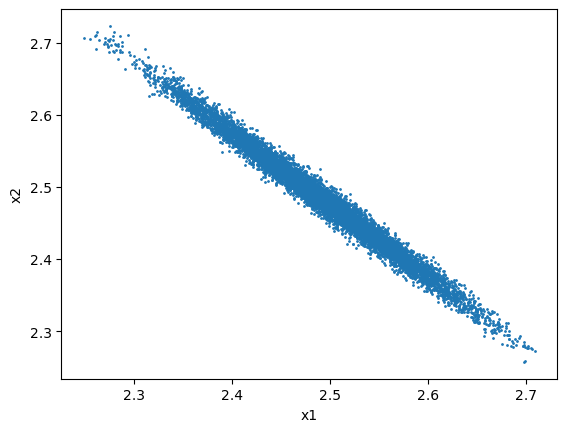

In [12]:
burnin = 500
num_samples = 10000

y = 5.0
mu1 = 0
mu2 = 0
sig1 = 0.1
sig2 = 0.1
sig_y = 0.01


def gibbs_sampling(num_samples):
    x1 = 2.5
    x2 = 2.5
    samples = [(x1, x2)]
    
    
    for i in range(num_samples):
        x1 = np.random.normal((mu1 * sig_y**2 + (y - x2)*sig1**2)/(sig1**2 + sig_y**2), np.sqrt(sig1**2 * sig_y**2 / (sig1**2 + sig_y**2) ))
        x2 = np.random.normal((mu2 * sig_y**2 + (y - x1)*sig2**2)/(sig2**2 + sig_y**2), np.sqrt(sig2**2 * sig_y**2 / (sig2**2 + sig_y**2) ) )

        samples.append((x1, x2))

    return np.array(samples)

# Example usage
gibbs_samples_from0 = gibbs_sampling(num_samples)
gibbs_samples = gibbs_samples_from0[: - burnin]

#print("Gibbs sampling results:")
#for i, (x1, x2) in enumerate(gibbs_samples):
#    print(f"Sample {i+1}: x1 = {x1}, x2 = {x2}")
x1_chain = gibbs_samples[:,0]
x2_chain = gibbs_samples[:,1]
#print(full_cond_1(0,0,0.02))
  

# uncomment and plot your results (do not remove)
plt.scatter(x1_chain, x2_chain, s=1)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

We note that the probability of $y = 5.0$ is very small, due to the prior distributions of x_1 and x_2. We are therefore sampling from a distribution conditioned on a tail event, which is the reason why it would be very hard to sample from normalised conditional distributions with rejection sampling or importance sampling. The posterior takes this form, because out the probability of $x_1 + x_2 = 5$ is the greatest when the latent variables are equal, and decreases at least exponentially with $|x_1 - x_2|$. It follows the shape of the line $x + y = 5$ in $\mathbb{R}^2$ due to the model of the likelihood. 